In [1]:
from pathlib import Path
import asyncio
from IPython.display import display
from server import LlamaServer

Download the quantized LLaVa model on [huggingface](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main) and save them to the folder "llms"


In [2]:
config = {
    "alias": "LLaVA 1.5",
    "model": "./llms/llava-v1.5-q5_k.gguf",
    "multimodal_projector": "./llms/llava-mmproj-f16.gguf",
    "server_exe": "../llama_server",
    "system_prompt": "./llava_prompt.json",
    "prefix": "User:",
    "suffix": "\nAssistant:",
}
slots = 5
llm = LlamaServer(config, context_size=4096, slots=slots)

2023-11-01 17:26:18.966 GMT: Multimodal inference currently only works with one slot. Slot number is changed to 1.


In [3]:
llm.stop_server()
proc = await llm.start_server()

2023-11-01 17:26:19.848 GMT: Llama server is already offline.
2023-11-01 17:26:22.858 GMT: Server online.


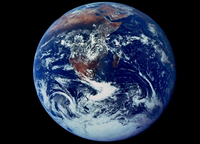

The image is a close-up of the Earth from space, showing its oceans and land masses. It appears to be a black and white photo, giving it an artistic feel. The Earth's surface is visible in great detail, with the continents and countries clearly distinguishable.


In [4]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", slot_id=0)
display(image)
print(result["answer"].strip())

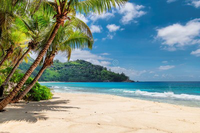

The image features a beautiful beach with palm trees and blue water. There are several people enjoying the sunny day, some of them standing near the water while others are scattered across the beach. A few boats can be seen in the background, adding to the picturesque scene. The overall atmosphere is relaxing and inviting for visitors seeking a vacation or leisurely time by the ocean.


In [5]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/beach.jpg", slot_id=0)
display(image)
print(result["answer"].strip())

#### Update system prompt at runtime

In [6]:
system_prompt = {
    "system_prompt": {
    "prompt": (
        "You are a helpful language and vision assistant. "
        "You are able to understand the visual content that the user provides, "
        "and assist the user with a variety of tasks using natural language."
              ),
    "anti_prompt": "User",
    "assistant_name": "Assistant"
    }
}
await llm.update_system_prompt(system_prompt)

True

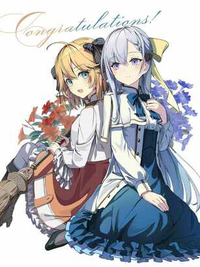

The image is a colorful anime-style illustration featuring two young women. One woman is sitting down, holding flowers in her hand, while the other woman stands behind her. Both are wearing blue dresses and have long hair. They appear to be enjoying each other's company as they pose for the picture.


In [7]:
prompt = "Please describe concisely the content in the above figure."
result, image = await llm.query(prompt, "./figures/girls.jpg", slot_id=0, seed=0)
display(image)
print(result["answer"].strip())


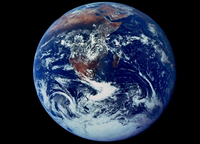

A blue and white globe,
A world of oceans and land.
The continents are visible,
And the atmosphere is vast.
This image captures our home,
In all its beauty and grandeur.


In [8]:
prompt = "Please write a short poem based on the content in the above figure."
result, image = await llm.query(prompt, "./figures/earth.jpg", slot_id=0, seed=0)
display(image)
print(result["answer"].strip())


### Batch evaluation

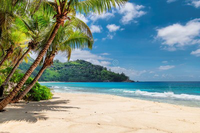

A beautiful beach with a clear blue ocean and palm trees.


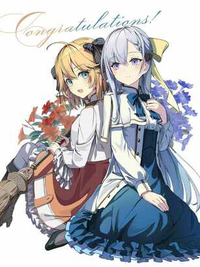

Two anime girls are sitting next to each other, with one girl holding a bouquet of flowers. They both have long hair and are wearing dresses. The scene is set in front of a blue background with some purple accents.


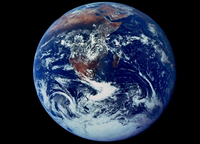

The image is a close-up of the Earth, showing its surface and oceans. The Earth appears to be blue with white clouds scattered across it.


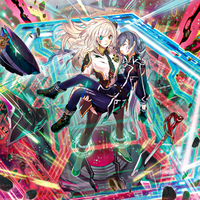

The image features two anime-style characters, a woman and a girl, standing in front of each other. They are both wearing costumes, with the woman being taller than the girl. One of them is holding the other on her shoulders, creating a sense of connection between them.

The scene takes place within a colorful environment that includes multiple objects such as a chair and a dining table in the background. There are also two swords visible in the image, one closer to the woman and the other nearer to the girl. The overall setting appears to be an artistic or imaginative space where these characters interact with each other.


In [9]:
images = [f.as_posix() for f in Path("figures/").glob("*.jpg")]
prompts = ["Please describe concisely the content in the above figure."] * len(images)
results, images = await llm.batch_query(prompts,images)
for image, result in zip(images, results):
    answer = result["answer"].strip()
    display(image)
    print(answer)

#### Some dumb questions without figures.

In [10]:
prompts = [
    "How to build a website?",
    "Teach me how to calculate $\pi$?"
]
results, _ = await llm.batch_query(prompts)
for prompt, result in zip(prompts, results):
    answer = result["answer"].strip()
    print(f"Q: {prompt}\nA: {answer}")
    print("-"*20)

Q: How to build a website?
A: Building a website involves several steps, which are outlined below:

1. Choose a domain name and hosting provider: First, you need to choose a unique and memorable domain name for your website and select a reliable web hosting provider that offers the necessary resources like storage, bandwidth, and security features.
2. Plan your website structure: Determine the purpose of your website and create a sitemap or blueprint outlining its pages, sections, and content. This will help you organize your website effectively and make it easy for users to navigate.
3. Design your website: Choose a suitable design template that aligns with your brand identity and target audience. You can either use a pre-made template or hire a web designer to create a custom design for you.
4. Develop the content: Write engaging and informative content for each page of your website, including text, images, videos, and other multimedia elements. Ensure that the content is well-struct

In [11]:
llm.stop_server()

-15

In [12]:
!nvidia-smi

Wed Nov  1 17:29:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 46%   57C    P8    21W / 250W |     17MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 38%   